In [1]:
%run ../robustness_analysis.ipynb

## Define parametric environment

In [2]:
from lunarlander import LunarLander, INITIAL_RANDOM

## Define deviation domain

In [3]:
# define variables and their bounds
wind_power = [0.0, 20.0]
turbulence_power = [0.0, 2.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([wind_power, turbulence_power])

# define the range of initial force apply to the lander
x0_bounds = np.repeat([[-INITIAL_RANDOM, INITIAL_RANDOM]], 2, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([5.0, 0.5])

## Define system and controller

In [4]:
def env_builder(delta):
    return LunarLander(enable_wind=True, continuous=True, wind_power=delta[0], turbulence_power=delta[1]), x0_bounds

In [5]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor

# Copy the hyperparameters from Stable-baselines3 zoo
# LunarLander-v2:
#   n_envs: 16
#   n_timesteps: !!float 1e6
#   policy: 'MlpPolicy'
#   n_steps: 1024
#   batch_size: 64
#   gae_lambda: 0.98
#   gamma: 0.999
#   n_epochs: 4
#   ent_coef: 0.01

model_name = 'ppo.zip'

if os.path.exists(model_name):
    model = PPO.load(model_name)
else:
    env = VecMonitor(SubprocVecEnv([
        lambda: env_builder(delta_0)[0] for _ in range(12)
    ]))
    model = PPO('MlpPolicy', env, n_steps=1024, batch_size=64, gae_lambda=0.98, gamma=0.999,
                n_epochs=4, ent_coef=0.01, tensorboard_log='./ppo-tensorboard/')
    model.learn(total_timesteps=int(3e6))
    model.save(model_name)

agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: model.predict(obs, deterministic=True)[0],

    # some agents (like PID) needs to be reset for each run
    'model_reset': None
}

In [6]:
# from stable_baselines3.common.evaluation import evaluate_policy

# env = VecMonitor(SubprocVecEnv([
#     lambda: env_builder(delta_0)[0] for _ in range(12)
# ]))
# evaluate_policy(model, env, n_eval_episodes=10)

## Define STL property

In [7]:
obs_space = env_builder(delta_0)[0].observation_space
angle_range = np.asarray([obs_space.low[4], obs_space.high[4]])
x_range = np.asarray([obs_space.low[0], obs_space.high[0]])
y_range = np.asarray([obs_space.low[1], obs_space.high[1]])


def stl_prop():    
    # G ( |angle| < 45 && |x| < 0.6|y| + 0.1 )
    angle = stl.Predicate('angle')
    delta_x = stl.Predicate('delta_x')
    
    angle_threshold = normalize(45 * 2 * np.pi / 360, angle_range)
    
    return stl.Always( (angle < angle_threshold) & (delta_x < 0.1) )
    

def signal_builder(records, time_index):    
    return {
        'angle': stl.Signal(
            normalize(np.abs(records[:, 4]), angle_range),
            time_index
        ),
        'delta_x': stl.Signal(
            normalize(np.abs(records[:, 0]), x_range) - normalize(np.abs(0.6 * records[:, 1]), y_range),
            time_index
        )
    }
    

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

## Define distance function

In [8]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

In [9]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')

## Create the baseline Robustness Analyzer

In [10]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['steps_of_each_x0'] = 300
analysis.options['deviation_restarts'] = 2
analysis.options['deviation_sigma'] = 0.2
analysis.options['deviation_evals'] = 100
# analysis.options['deviation_timeout'] = 20
analysis.options['falsification_sigma'] = 0.4
analysis.options['falsification_timeout'] = 1
analysis.options['falsification_restarts'] = 1
analysis.options['falsification_episodes'] = 40
analysis.options

{'epsilon': 0.01,
 'deviation_restarts': 2,
 'deviation_sigma': 0.2,
 'deviation_timeout': inf,
 'deviation_evals': 100,
 'falsification_sigma': 0.4,
 'falsification_timeout': 1,
 'falsification_restarts': 1,
 'falsification_episodes': 40,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 300}

In [11]:
start = datetime.now()
analysis.deviated_sys_eval([5.1, 0.2])
datetime.now() - start

datetime.timedelta(seconds=13, microseconds=816310)

## Min deviation and Plot the convergence

In [12]:
def min_dev_and_convergence(analysis, out_dir='data'):
    start = datetime.now()
    result = analysis.min_unsafe_deviation()
    print('===================== Summary ====================>')
    print('Time to find min unsafe deviation:', datetime.now() - start)
    print('Min x:', result.delta, 'Min distance:', result.delta_dist)
    
    for i in range(len(result.Dists)):
        analysis.heatmap(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces", z_name="STL Satisfaction",
                         out_dir=out_dir, boundary=result.Dists[i])
        plt.scatter(result.Xss[i][:, 0] * 24, result.Xss[i][:, 1] * 24, c=np.arange(len(result.Xss[i])), cmap='Greys')
        if result.Means is not None and result.Sigmas is not None:
            plt.title(f'Mean: {result.Means[i]}, Sigma: {result.Sigmas[i]}')
        plt.show()

### BasicCMA

In [ ]:
min_dev_and_convergence(analysis)

### Random

In [ ]:
min_dev_and_convergence(RandomMinDev(analysis))

### SmartCMA

In [ ]:
min_dev_and_convergence(SmartCMA(analysis))

## Compare the number of evaluations

In [13]:
def run_data(analysis, name, n=10, evals=50, out_dir='data'):
    dists_name = f"{out_dir}/{name}-dists-{n}-{evals}.csv"
    times_name = f"{out_dir}/{name}-times-{n}-{evals}.csv"
    if os.path.exists(dists_name) and os.path.exists(times_name):
        dists = np.loadtxt(dists_name, delimiter=',')
        times = np.loadtxt(times_name, delimiter=',')
    else:
        analysis.options['deviation_evals'] = evals
        dists, times = [], []
        for _ in range(n):
            start = datetime.now()
            result = analysis.min_unsafe_deviation()
            dists.append(result.delta_dist)
            times.append((datetime.now() - start).total_seconds())

        dists, times = np.array(dists), np.array(times)
        np.savetxt(dists_name, dists, delimiter=',')
        np.savetxt(times_name, times, delimiter=',')
    return dists, times

In [14]:
def test_evals(analysis, name, out_dir):
    evals = np.arange(25, 126, 25)
    data = []
    for e in evals:
        dists, _ = run_data(analysis, name, evals=e, out_dir=out_dir)
        data.append(dists)
    # plt.boxplot(data, labels=evals)
    # plt.show()
    return data

### Basic CMA

In [15]:
data1 = test_evals(analysis, 'BasicCMA', 'data')


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=374761, Mon Dec  5 20:48:04 2022)
=============== CMA Results:=================>
CMAEvolutionStrategyResult(xbest=array([0.36922286, 0.00306413]), fbest=6.474436992221033e-07, evals_best=7, evaluations=54, iterations=9, xfavorite=array([0.23182425, 0.25948238]), stds=array([0.03468032, 0.04071905]), stop={'maxfevals': 50})
=============================================>
{'x': array([0.2281932 , 0.28083909]), 'f': 0.03777017288396828, 'g': [-0.0006920337677001898], 'f_al': 0.03686963134062258, 'g_al': [-0.0009005415433457015], 'count': 48}

================ Min unsafe deviation trial 2 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=398587, Mon Dec  5 21:00:33 2022)
=============== CMA Results:=================>
CMAEvolutionStrategyResult(xbest=array([0.27925895, 0.27172692]), fbest=0.026867608122876942, evals_best=39, evaluations=54, iterations=9

### Random sample

In [16]:
data2 = test_evals(RandomMinDev(analysis), 'Random', 'data')

### SmartCMA

In [ ]:
data3 = test_evals(SmartCMA(analysis), 'SmartCMA', 'data')

In [17]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def boxplot(datas, colors, labels, legends):
    num_group = len(datas)
    num_each_group = len(datas[0])
    total = num_group * num_each_group
    for i in range(num_group):
        bp = plt.boxplot(datas[i], positions=np.arange(i+1, total+1, num_group))
        set_box_color(bp, colors[i])
    
    plt.xticks(np.arange(1+(num_group-1)/2, total, num_group), labels=labels)

    for i in range(num_group):
        plt.plot([], c=colors[i], label=legends[i])
    plt.legend()

    plt.show()

In [ ]:
boxplot([data1, data2, data3], ['red', 'blue', 'green'], np.arange(50, 151, 25)*(analysis.options['deviation_restarts']+1),
        ['BasicCMA', 'Random', 'SmartCMA'])

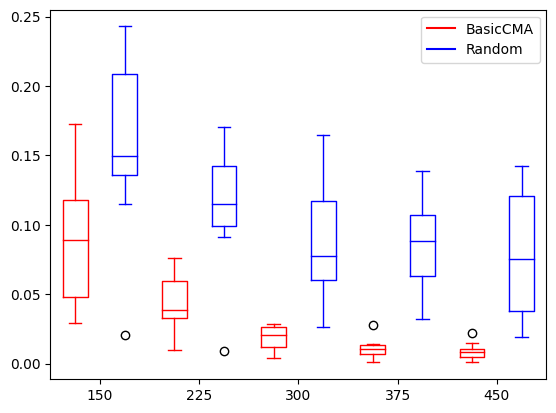

In [18]:
boxplot([data1, data2], ['red', 'blue'], np.arange(50, 151, 25)*(analysis.options['deviation_restarts']+1),
        ['BasicCMA', 'Random'])